In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
!pip3 install seaborn

    100% |████████████████████████████████| 215kB 14.9MB/s ta 0:00:01
You are using pip version 19.0.3, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
%load_ext autoreload
%autoreload 2
from utils import *

import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import os
import lightgbm as lgbm
import warnings
from utils import *
import seaborn as sns
from sklearn.metrics import accuracy_score
from parameters import top_tickers, ibkr_tickers

sns.set()

warnings.filterwarnings('ignore')

In [ ]:
1

In [ ]:
load_tickers(data_prefix="data/train", tickers=ibkr_tickers, start_date=datetime.strptime("20170101", "%Y%m%d").date(), end_date=datetime.today().date() + timedelta(days=1), period=3)

 12%|█▏        | 5/41 [00:21<04:53,  8.17s/it]

AFLT
ALRS
CBOM
CHMF
DSKY
FEES
FIVE
GAZP
GMKN


 27%|██▋       | 11/41 [00:22<02:51,  5.72s/it]

HYDR
IRAO
LKOH
MAGN


 34%|███▍      | 14/41 [00:22<01:48,  4.02s/it]Process ForkPoolWorker-283:
Process ForkPoolWorker-281:
Process ForkPoolWorker-287:
Traceback (most recent call last):
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

Traceback (most recent call last):
Traceback (most recent call last):
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/

In [ ]:
1

In [5]:
ticker2df = load_dfs('data/train', ibkr_tickers)

ALRS
CBOM
CHMF
DSKY
FIVE
RNFT
SFIN


In [6]:
test_start_day = datetime.today().date() - timedelta(days=32)

train_dates = [test_start_day - timedelta(days=x) for x in range(1, 100)]
val_dates = [test_start_day + timedelta(days=x) for x in range(0, 30)]

In [7]:
X_train, y_train_series = all_samples(ticker2df, train_dates)
X_val, y_val_series = all_samples(ticker2df, val_dates)

In [8]:
def single_target_1(series):
    ser_len = len(series)
    if len(series) > 10:
        can_buy_price = series[1] * 1.005
        can_buy = (series < can_buy_price)[2:5].max()
        if can_buy:
            buy_idx = np.where(series[2:5] < can_buy_price)[0][0] + 1
            
#             can_sell_price = series[0] * 1.025
#             can_sell = (series > can_sell_price)[buy_idx:-3].max()

#             if can_sell:
#                 sell_idx = np.where((series > can_sell_price)[buy_idx:-3])[0][0] + 1
#             else:
#                 sell_idx = -3
#                 sell_idx = len(series[:-5]) + series[-5:].argmin()
                
            sell_idx = len(series[:-5]) + series[-5:].argmin()

            profit = (series[sell_idx] - series[buy_idx]) / series[buy_idx]
                
        else:
            profit = 0
            
    else:
        profit = 0
    
    return profit


def single_target_2(series):
    if len(series) > 10:
        #profit = (series[-5:].min() - series[1]) / series[1]#  > 0.01
        profit = (series[-1] - series[1]) / series[1]  #> 0.01

    else:
        profit = 0
    
    return profit



def single_profit_2(series, return_idxs=False):

    #profit = (series[-5:-4].min() - series[1]) / series[1]#  > 0.01
    #profit = (series[-1] - series[1]) / series[1]  #> 0.01

    UPPER_COEF = 1.003
    BUY_HORIZON = 8
    can_buy = (series[2:BUY_HORIZON] <= series[1]*UPPER_COEF).max()
    if can_buy:
        buy_idx = np.where(series[2:BUY_HORIZON] <= series[1]*UPPER_COEF)[0][0] + 2

        take_profit_price = series[buy_idx] * 1.01
        stop_loss_price = series[buy_idx] * 0.000000995

        take_profit_mask = series[buy_idx:-3] > take_profit_price
        stop_loss_mask = series[buy_idx:-3] < stop_loss_price

        can_sell = (take_profit_mask | stop_loss_mask).max()
        #can_sell = (take_profit_mask ).max()

        if can_sell:
            #sell_idx = np.where(take_profit_mask )[0][0] + 2
            sell_idx = np.where(take_profit_mask | stop_loss_mask)[0][0] + buy_idx
            profit = 0.01

        else:
            sell_idx = len(series)-3

        profit = (series[sell_idx] - series[buy_idx]) / series[buy_idx]
  
    else:
        profit = 0
        buy_idx = len(series)-1
        sell_idx = len(series)-1
        
    if return_idxs:
        return buy_idx, sell_idx
    else:
        return profit



def single_profit(series):
    if len(series) > 10:
        UPPER_COEF = 1.003
        can_buy = (series[2:6] <= series[1]*UPPER_COEF).max()
        if can_buy:
            buy_idx = np.where(series[2:6] <= series[1]*UPPER_COEF)[0][0] + 2
            sell_idx = len(series[:-5]) + np.random.randint(5)#+ series[-5:].argmin()
            sell_idx = -1
            profit = (series[sell_idx] - series[buy_idx]) / series[buy_idx]
        else:
            profit = 0
    else:
        profit = 0
        
    return profit


def calc_target(y_serieses, foo):
    target = []
    for ticker_serieses in y_serieses:
        for series in ticker_serieses:
            val = foo(series)
            target.append(val)
            
    return np.array(target)


def tmp_foo(y_serieses, foo):
    target = []
    k = 0
    for ticker_serieses in y_serieses:
        for series in ticker_serieses:
            val = foo(series)
            target.append(val)
            if k == 1496:
                return series
            k += 1


In [9]:
y_train_profit = calc_target(y_train_series, single_profit_2) 
y_val_profit = calc_target(y_val_series, single_profit_2)


y_train = calc_target(y_train_series, single_target_2) > 0.01
y_val = calc_target(y_val_series, single_target_2) > 0.01


# y_train = y_train_profit #> 0.005
# y_val = y_val_profit #> 0.005

# y_val_profit = calc_target(y_val_series, )


In [131]:
X_train.shape, X_val.shape

((2516, 48), (814, 50))

In [10]:
lgb = lgbm.sklearn.LGBMClassifier()
lgb.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train)

# lgb_2 = lgbm.sklearn.LGBMClassifier()
# lgb_2.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train_2)

# lgb_3 = lgbm.sklearn.LGBMClassifier()
# lgb_3.fit(X_train.drop(['corn_date', 'ticker'], axis=1), y_train_3)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
lgb.feature_importances_

array([ 95,  55,  31,  69,  17,  79,  77,  33,  47,  84,  34,  70,  74,
        72,  48,  78,  37,  67,  68,  43,  34,  68,  35, 106,  70,  68,
        37,  94,  40, 127,  69,  68,  40,  65,  41, 104,  11,  24,  60,
        63, 102,  36, 112, 132, 110, 106])

In [243]:
del X_val['profit']
del X_val['profit_abs']

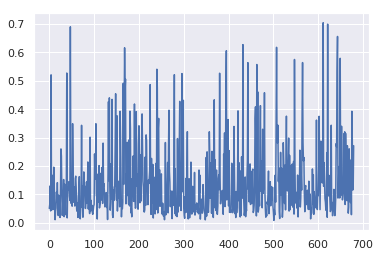

In [12]:
pred_proba = lgb.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
plt.plot(pred_proba)
plt.show()

# pred_proba_2 = lgb_2.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_2)
# plt.show()

# pred_proba_3 = lgb_3.predict_proba(X_val.drop(['corn_date', 'ticker'], axis=1))[:, 1]
# plt.plot(pred_proba_3)

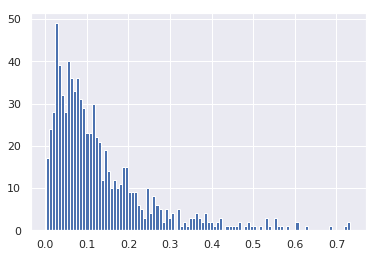

In [245]:
plt.hist(pred_proba, bins=100)
plt.show()

In [13]:
top_idxs = np.where(pred_proba > 0.7)[0]
top_idxs = np.where(pred_proba > 0.4)[0]


In [14]:
len(top_idxs)#, len(top_idxs_2), len(top_idxs_3)

38

In [19]:
y_val.mean(), y_val[top_idxs].mean()

(0.1411764705882353, 0.10526315789473684)

In [16]:
X_val['profit'] = y_val_profit
day_cnt_df = X_val.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_val = pd.merge(X_val, day_cnt_df, on='corn_date', how='left')
X_val['volume'] = 3000000 / X_val['cnt_per_day']
X_val['profit_abs'] = X_val['volume'] * X_val['profit']
del X_val['cnt_per_day']
del X_val['volume']

In [46]:
X_val

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,ticker,corn_date,profit,profit_abs
0,0.019799,0.965615,0.914112,0.971189,0.085888,0.081757,0.007611,0.982944,0.972711,0.980757,...,0.998265,0.918450,NaN,0.001735,91.98000,-0.002174,MOEX,2019-07-03,0.010019,15027.768703
1,0.020890,0.957049,0.904280,0.961551,0.095720,0.088621,0.010998,0.978255,0.963003,0.974080,...,0.998066,0.908148,0.001078,0.009558,92.70000,-0.002157,MOEX,2019-07-04,0.011553,8664.435327
2,0.019781,0.947863,0.899258,0.949311,0.100742,0.100530,0.013363,0.970916,0.949523,0.973383,...,0.996947,0.909434,NaN,0.003053,94.30000,-0.000848,MOEX,2019-07-05,0.010179,NaN
3,0.018124,0.939628,0.903710,0.935807,0.096290,0.088370,0.015876,0.964653,0.939246,0.963735,...,0.991246,0.906628,NaN,0.001876,95.30000,0.001364,MOEX,2019-07-08,0.010537,31612.223393
4,0.020935,0.935074,0.904324,0.927547,0.095676,0.089896,0.017052,0.966538,0.938281,0.962535,...,0.996134,0.907224,0.000985,0.014478,96.42000,-0.000519,MOEX,2019-07-09,-0.014685,-44053.774560
5,0.023820,0.937041,0.903578,0.927091,0.096422,0.078478,0.016043,0.975048,0.946375,0.978034,...,0.995130,0.906500,0.012146,0.002464,95.32000,0.002098,MOEX,2019-07-10,-0.001689,-2532.981530
6,0.024689,0.938832,0.903578,0.927916,0.096422,0.075178,0.012316,0.979478,0.951428,0.979375,...,0.995130,0.906500,0.015446,0.001111,95.00000,0.003474,MOEX,2019-07-11,0.003600,10800.508259
7,0.025066,0.941784,0.907497,0.930185,0.092503,0.060844,0.008441,0.982540,0.968856,0.979581,...,0.995328,0.919644,0.016675,0.001078,94.90000,0.002213,MOEX,2019-07-12,-0.009524,-9523.809524
8,0.025195,0.945076,0.913685,0.933381,0.086315,0.046819,0.010032,0.980421,0.957925,0.977519,...,0.994769,0.919788,0.002166,0.003937,93.97000,-0.003193,MOEX,2019-07-15,0.010095,15141.855276
9,0.025289,0.947527,0.913685,0.934928,0.086315,0.059606,0.008745,0.977108,0.957925,0.976591,...,0.994769,0.919788,0.013228,0.003337,95.18000,0.001261,MOEX,2019-07-16,-0.013064,-19595.448799


In [17]:
X_val.loc[top_idxs].groupby('corn_date')['profit_abs'].sum()

corn_date
2019-07-08      140.599494
2019-07-09    -8574.928542
2019-07-10        0.000000
2019-07-11    37402.417621
2019-07-12    11509.458923
2019-07-15   -26134.125870
2019-07-17    -2705.409429
2019-07-18     9952.856835
2019-07-19    16360.236834
2019-07-22   -50576.690053
2019-07-23    10653.604526
2019-07-24   -10089.215225
2019-07-26     3082.061185
2019-07-29    33046.471601
2019-07-30   -30931.542980
2019-08-02    -3723.781983
Name: profit_abs, dtype: float64

In [ ]:
5

In [31]:
7 - 5

2

3610.7999999999997

In [62]:
def round_price(price):
    for k in range(1, 10):
        new_price = round(price, k)
        if np.abs(price - new_price) / price < 0.0001:
            break


    for min_clip in [5 / (10 ** k), 2 / (10 ** k)]:
        clipped_price = round(float(price) / min_clip) * min_clip
        if np.abs(price - clipped_price) / price < 0.0001:
            return clipped_price
        
    return new_price

In [64]:
round_price(2380.0 * 1.003)

2387.0

In [65]:
2380.0 * 1.003

2387.14

In [40]:

round(3600.0 * 1.003 , 1)

3610.8

In [57]:
price = 3600.0 * 1.003
np.abs(round(price , 2) - price ) / price

1.2594088592180795e-16

In [60]:
for k in range(1, 10):
    new_price = round(price, k)
    if np.abs(price - new_price) / price < 0.0001:
        break
        

for min_clip in [5 / (10 ** k), 2 / (10 ** k)]:
    clipped_price = round(float(price) / min_clip) * min_clip
    if np.abs(price - clipped_price) / price < 0.0001:
        break

In [61]:
clipped_price

3611.0

In [49]:
min(9, 10 - 9)

1

In [43]:
3600.0 * 1.003

3610.7999999999997

In [55]:
MinClip = 0.5
round(float(price) / MinClip) * MinClip

3611.0

In [18]:
X_val.loc[top_idxs]['profit_abs'].sum()

-10587.987063635159

In [ ]:
91517.8617101984
84287.5011097007

In [ ]:
274337.9430807853
175824.31807198492

In [112]:
X_day = X_val.loc[top_idxs]
X_day = X_day[X_day['corn_date'] == datetime.strptime("20190703", "%Y%m%d").date()]

In [113]:
X_day

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,ticker,corn_date,profit,profit_abs
66,0.069627,0.881841,0.770059,0.891292,0.229941,0.142368,0.015435,0.96123,0.927078,0.960158,...,0.983742,0.777027,0.014954,0.00595,4.725,0.003175,IRAO,2019-07-03,0.013473,40420.114577


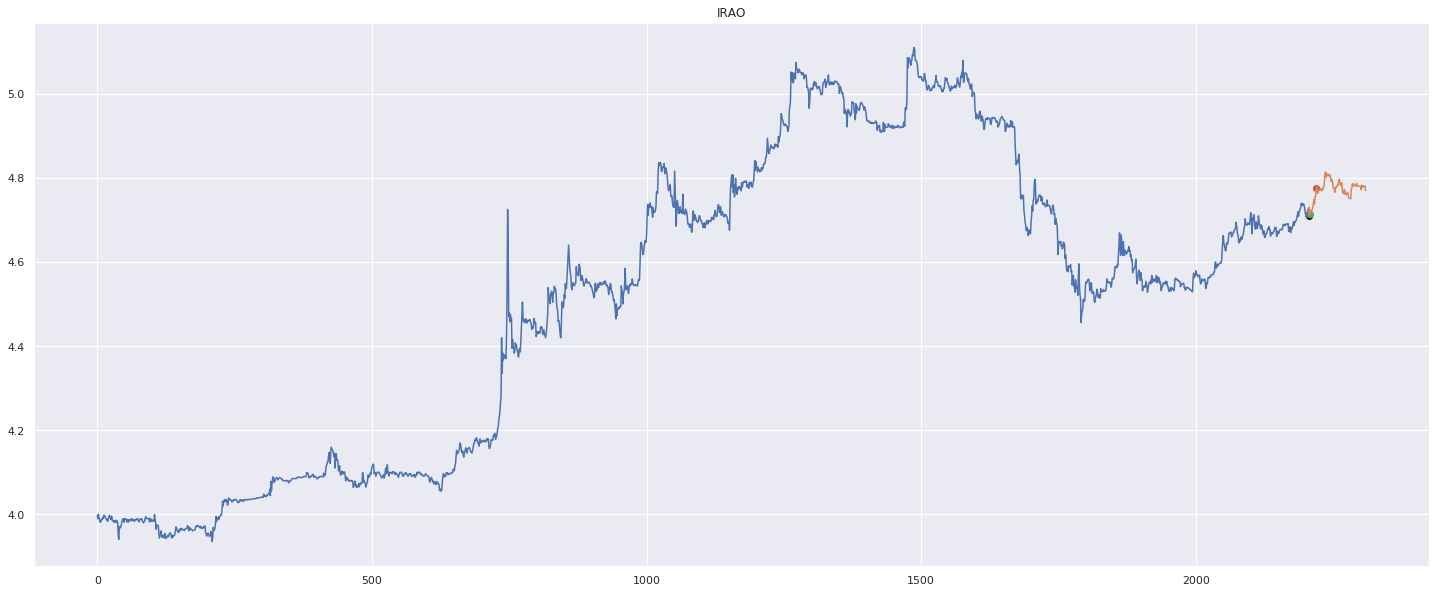

In [114]:
idx = top_idxs[0]
idx = 66
#for idx in top_idxs:
corn_date = X_val.loc[idx]['corn_date']
ticker = X_val.loc[idx]['ticker']

df = ticker2df[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()

# Inference

In [683]:

train_dates = [datetime.today().date() - timedelta(days=x) for x in range(1, 100)]

In [48]:
test_start_day

datetime.date(2019, 7, 4)

In [297]:
%%time
ticker2df = load_dfs('data/train', top_tickers[:100])

CPU times: user 1min, sys: 8.17 s, total: 1min 8s
Wall time: 59.6 s


In [20]:
load_tickers(data_prefix="data/current", tickers=ibkr_tickers, start_date=datetime.today().date() - timedelta(days=40), end_date=datetime.today().date(), period=3)

 12%|█▏        | 5/41 [00:06<00:49,  1.37s/it]

DSKY


 17%|█▋        | 7/41 [00:08<00:38,  1.14s/it]

FIVE


 61%|██████    | 25/41 [00:29<00:21,  1.34s/it]

RNFT


 76%|███████▌  | 31/41 [00:35<00:11,  1.19s/it]

SFIN


100%|██████████| 41/41 [00:46<00:00,  1.34s/it]


In [21]:
ticker2df_test = load_dfs('data/current', ibkr_tickers)

DSKY
FIVE
RNFT
SFIN


In [22]:
X_test, y_test_series = all_samples(ticker2df_test, [datetime.today().date()], test_mode=True)

In [23]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,ticker,corn_date
0,0.022530,0.967054,0.913449,0.972874,0.086551,-0.075700,0.013556,0.977190,0.956154,0.978341,...,0.919569,NaN,0.997377,0.919569,0.006120,NaN,144.80000,-0.001381,NLMK,2019-08-07
1,0.022820,0.953766,0.895782,0.951376,0.104218,-0.066069,0.020093,0.957965,0.925351,0.948634,...,0.934732,0.917888,0.997895,0.909467,0.013558,0.003285,226.01000,0.000531,SBER,2019-08-07
2,0.010487,0.974472,0.951327,0.974931,0.048673,-0.029094,0.011561,0.983710,0.960118,0.989106,...,0.955751,NaN,0.996067,0.955751,0.004242,NaN,26.00000,0.000000,SNGS,2019-08-07
3,0.017776,0.966464,0.915570,0.968119,0.084430,-0.053072,0.017283,0.966376,0.938169,0.956767,...,0.943713,0.930921,0.997442,0.930921,0.006620,0.006172,197.23000,0.000000,SBERP,2019-08-07
4,0.022598,0.958070,0.884693,0.962767,0.115307,-0.091227,0.029708,0.962730,0.917795,0.980357,...,0.898670,0.888187,0.996506,0.888187,0.009521,0.000961,4.19100,-0.006204,IRAO,2019-08-07
5,0.015564,0.937711,0.886000,0.938078,0.114000,-0.028406,0.015866,0.960631,0.920806,0.966026,...,0.907879,0.892909,0.991939,0.892909,0.001213,0.013757,2413.00000,-0.002901,YNDX,2019-08-07
6,0.043991,0.900843,0.850107,0.881908,0.149893,-0.127109,0.010183,0.982589,0.962500,0.983696,...,0.886444,0.872818,0.989401,0.863733,0.013553,0.000073,0.18006,0.000000,FEES,2019-08-07
7,0.015408,0.965070,0.939414,0.963722,0.060586,-0.017165,0.009143,0.981861,0.963209,0.981225,...,0.984700,0.965117,0.996328,0.944309,0.013370,0.006214,5234.50000,0.000096,LKOH,2019-08-07
8,0.030167,0.935086,0.896472,0.919028,0.103528,-0.068537,0.005598,0.987572,0.976993,0.986448,...,0.910067,NaN,0.994771,0.910067,0.002316,NaN,156950.00000,0.003504,TRNFP,2019-08-07
9,0.018490,0.955641,0.919253,0.954788,0.080747,-0.061895,0.010359,0.979660,0.961626,0.979766,...,0.922515,NaN,0.991844,0.922515,0.001594,NaN,0.55200,-0.000181,HYDR,2019-08-07


In [ ]:
del X_test['profit']

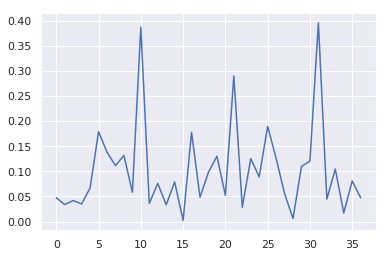

In [24]:
pred_proba = lgb.predict_proba(X_test.drop(['corn_date', 'ticker'], axis=1))[:, 1]
plt.plot(pred_proba)
plt.show()


In [29]:
top_idxs = np.where(pred_proba > 0.2)[0]


In [30]:
ticker2price = {}

for ticker in list(X_test.loc[top_idxs, ['ticker', 'corn_date']]['ticker'].values):
    
    df = ticker2df_test[ticker]
    price = df[df['date']==datetime.today().date()]['<OPEN>'].values[0]
    
    ticker2price[ticker] = price


ticker2price

{'GAZP': 226.92, 'MGNT': 3600.0, 'TRMK': 56.56}

In [330]:
y_test_profit = calc_target(y_test_series, single_profit_2)

In [334]:
X_test['profit'] = y_test_profit
day_cnt_df = X_test.loc[top_idxs].groupby('corn_date').size().reset_index().rename({0:'cnt_per_day'}, axis=1)
X_test = pd.merge(X_test, day_cnt_df, on='corn_date', how='left')
X_test['volume'] = 3000000 / X_test['cnt_per_day']
X_test['profit_abs'] = X_test['volume'] * X_test['profit']
del X_test['cnt_per_day']
del X_test['volume']

In [336]:
top_idxs

array([ 4, 12, 22])

In [329]:
X_test.loc[top_idxs, ['ticker', 'corn_date']]

,ticker,corn_date
4,YNDX,2019-08-06
12,GAZP,2019-08-06
22,NVTK,2019-08-06


In [363]:
X_test.loc[top_idxs, ['ticker', 'corn_date', 'profit', 'profit_abs']]

,ticker,corn_date,profit,profit_abs
4,YNDX,2019-08-06,0.01985,19850.281773
12,GAZP,2019-08-06,0.00000,0.000000
22,NVTK,2019-08-06,0.01040,10400.496740


In [1082]:
X_test.loc[top_idxs, ['profit']].sum()

profit   -8149.544299
dtype: float64

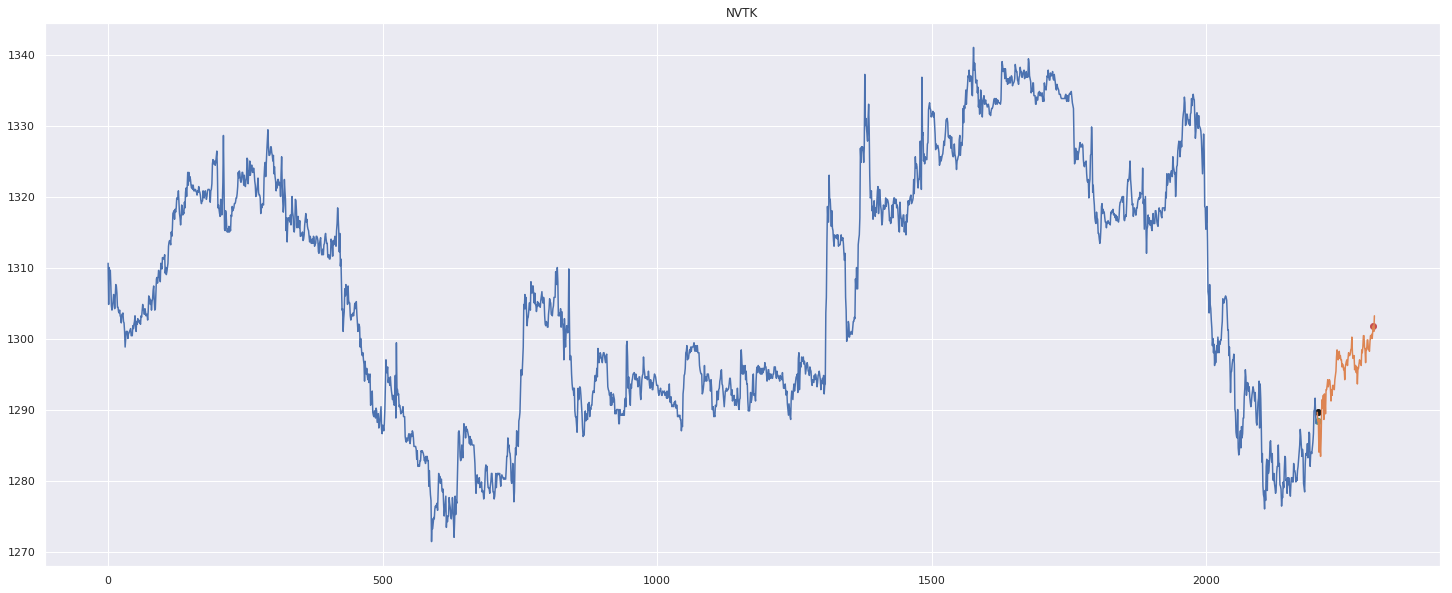

In [362]:
idx = 22
#for idx in top_idxs:
corn_date = X_test.loc[idx]['corn_date']
ticker = X_test.loc[idx]['ticker']

df = ticker2df_test[ticker]
month_series = df_between(df, corn_date - timedelta(days=31), corn_date)['<OPEN>'].values
target_series = df_between(df, corn_date, corn_date + timedelta(days=1))['<OPEN>'].values


plt.figure(figsize=(25,10))
plt.title(ticker)
plt.plot(range(len(month_series)), month_series)
plt.plot(range(len(month_series), len(month_series) + len(target_series)), target_series)

buy_idx, sell_idx = single_profit_2(np.array([0] + list(target_series)), return_idxs=True)
plt.scatter(len(month_series) + 1, target_series[0], color='k')
plt.scatter(len(month_series) + buy_idx - 1, target_series[buy_idx - 1], color='g')
plt.scatter(len(month_series) + sell_idx - 1, target_series[sell_idx - 1], color='r')

#plt.plot(range(len(month_series), len(month_series) + len(target_series)), y_val_series[84][-8], color='r')




plt.show()

In [353]:
    series = np.array([0] + list(target_series))
    UPPER_COEF = 1.003
    BUY_HORIZON = 118
    can_buy = (series[2:BUY_HORIZON] <= series[1]*UPPER_COEF).max()

In [354]:
can_buy

False

In [352]:
series[2:BUY_HORIZON] <= series[1]*UPPER_COEF

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [356]:
series

array([  0.  , 223.62, 225.25, 225.69, 225.52, 226.03, 225.69, 224.99,
       225.61, 225.81, 225.4 , 225.53, 225.33, 225.2 , 224.4 , 224.64,
       224.66, 225.03, 224.94, 225.13, 224.96, 225.48, 225.53, 225.64,
       225.49, 225.4 , 224.88, 225.23, 225.08, 225.3 , 225.35, 225.28,
       225.39, 225.35, 225.58, 225.59, 225.8 , 225.69, 225.45, 225.42,
       225.29, 225.27, 225.05, 225.26, 225.49, 225.4 , 225.33, 225.15,
       225.46, 225.44, 226.29, 226.2 , 225.98, 226.14, 226.12, 226.48,
       226.47, 227.21, 227.35, 226.8 , 226.63, 227.17, 227.06, 226.84,
       226.89, 226.69, 226.5 , 226.56, 226.31, 226.54, 226.55, 226.68,
       226.34, 226.4 , 226.55, 226.51, 226.4 , 226.53, 226.63, 226.28,
       226.7 , 226.12, 226.58, 226.69, 227.16, 227.23, 227.27, 227.17,
       226.93, 226.71, 226.93, 226.66, 226.99, 226.94, 226.95, 227.05,
       226.85, 226.95, 226.84, 226.61, 226.47, 226.54, 226.9 , 226.98,
       227.04, 226.76])

In [ ]:
data_prefix='data/train'
start_date=datetime.today().date() - timedelta(days=1)
end_date = datetime.today().date() + timedelta(days=1)

ticker='LKOH'
load_single(ticker, 'data/temp', start_date, end_date, 3)


df = pd.read_csv('data/train/{}.csv'.format(ticker))
df['date'] = df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())

upd_df = pd.read_csv('data/temp/{}.csv'.format(ticker))
upd_df['date'] = upd_df['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d").date())